#### This Notebook is the sample Demo setup for working with DakkoAI Client Library


In [1]:
# Import dakko library
from dakkoai import (
    DakkoAIClient,
    DakkoRegistrationModel,
    DakkoSearch,
)

# Import supporting DataScience lib
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from functools import reduce
import pandas as pd

##### We will first create DakkoAI Client instance that we will be using throughout this Notebook


In [2]:
# Create dakko_client
dakko_client = DakkoAIClient()

#### Next we have two options

1. We can register a new developer account with Dakko
2. We can also use pre-registered account

These accounts will be used to fetch OAuth Access_Token that is mandatory to access any API from Dakko AI.


In [3]:
# Register new crypto Data Scientist
user_data = DakkoRegistrationModel(
    email="user@example.com", first_name="John", last_name="Doe", user_name="johndoe"
)

status = dakko_client.register(user_data)
print(f"Register User: {status}")
print(dakko_client.client_credentials.model_dump())

Register User: {'status': 'ok'}
{'email': 'user@example.com', 'client_id': 'hAayceQBjL00GgFA35hiALZWAZnbXQlX8LImBqG601BaH9NL', 'client_secret': 'MDDCQGJAUGTEdQRA6DwqGNzzovWqWJfsXhp9bsI3TVHujgevGgmuEECx4KYOE0TG'}


##### Now we will fetch the Access Token that will be used later


In [4]:
# Get access credentials for further connection to Dakko
status = dakko_client.get_access_token()

print(f"Getting access token: {status}")
print(dakko_client.access_credentials.model_dump())

Getting access token: {'status': 'ok'}
{'client_id': 'hAayceQBjL00GgFA35hiALZWAZnbXQlX8LImBqG601BaH9NL', 'access_token': 'lw34Nw2hZM1lv58JYxSNCsfO1Ipd'}


#### Search and fetch Pool information from DakkoAI

##### DakkoAI SDK provides two options for each execution

1. Fetch raw data as JSON
2. Fetch data in dataframe object that can be directly consumed for further analysis


In [5]:
# Search for Significant events from Dakko
dakko_search_significant_events = DakkoSearch(
    query="liquidity_change", limit=10, offset=0
)

se_result = dakko_client.get_significant_events(dakko_search_significant_events)

print("Search for Top Significant Events Dataframe")
se_result.dataframe

Search for Top Significant Events Dataframe


,event_id,event_type,meta,details
0,fdc1a49b2da04395823f3e07bfae9b35,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
1,e6d2d8e8bd784a9491da80770416c224,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
2,1f4adf8bd07c434aaad950d264558692,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
3,e42bb85b95d04ba3bf2e3b7f3a6ba514,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
4,e5fad78e41fa4fd2b51d7145a782feac,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
5,094ca3114aca4b32b27668c9266a9b6d,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
6,3fd8e6eb92714ac2a1db1c4736cc32d4,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
7,18c74544b5084bf9bb36efdd1311a06b,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
8,c1362904d73d4a0f99cb39451bd240d2,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."
9,ccbfb3dc1e10400a80911bfbda409dc9,liquidity_change,{'pool': '0xad9ef19e289dcbc9ab27b83d2df53cdeff...,"{'type': 'concentrated', 'reason': 'liquidityR..."


#### Search Pool information


In [6]:
# Search for Pools information
dakko_search_pool = DakkoSearch()

pools = dakko_client.get_pools(dakko_search_pool)

print("Search for Pools")
pools.dataframe

Search for Pools


,pool,address0,address1,symbol0,symbol1,dex,dec0,dec1
0,0x076a3e1500f3110d8f4445d396a3d7ca6d0ca269,0xfb66321d7c674995dfcc2cb67a30bc978dc862ad,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,PEPE2.0,WETH,uniswap,18,18
1,0x39d2978b70ed8db55d51834d4ee7ecb90a690620,0xa09e6f797223af66f3088ab8df35b2419165ea07,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,ETF,WETH,uniswap,9,18
2,0x91c40d69e2f957adc48adeaa541ee4a099832367,0x426aedbed16726e3f220cb4fed4d4060b95cca46,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,BAHAMAS,WETH,uniswap,18,18
3,0x8973be4402bf0a39448f419c2d64bd3591dd2299,0xa1d0e215a23d7030842fc67ce582a6afa3ccab83,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,YFII,WETH,uniswap,18,18
4,0x39f49254d6eaf6b2b2549dfec4ed93cf6bae167f,0x9e20461bc2c4c980f62f1b279d71734207a6a356,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,OMNI,WETH,sushiswap,18,18
5,0x61eb53ee427ab4e007d78a9134aacb3101a2dc23,0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,FXS,WETH,sushiswap,18,18
6,0xecba967d84fcf0405f6b32bc45f4d36bfdbb2e81,0x3432b6a60d23ca0dfca7761b7ab56459d9c964d0,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,FXS,WETH,uniswap,18,18
7,0xc0a6bb3d31bb63033176edba7c48542d6b4e406d,0x6de037ef9ad2725eb40118bb1702ebb27e4aeb24,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,RNDR,WETH,uniswap,18,18
8,0x19ffc51c7aec11f9b0f6027f895f68c02687bc07,0x6953f27db0701e22616e701dba91acc2e4b6deca,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,STAR,WETH,uniswap,18,18
9,0x922b01e8bf89e3d132f933467754912d4b580700,0x75d43d86cfb54b4bb2490bccb80d766d06b7273e,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,PYRO,WETH,uniswap,9,18


#### Run a SQL query against DakkoAI clean labelled data

These results will be utilized to do OHLCV analysis


In [7]:
# Fire a query on clean data tables and get raw JSON data
SEARCH_ADDRESS = "0xAD9eF19e289dcbC9AB27b83D2dF53CDEFF60f02D".lower()

dakko_sql = DakkoSearch(
    query=f"""
    
    WITH 
        Constants AS (
            SELECT '{SEARCH_ADDRESS}' AS contract, 
            18 AS dec0, 
            18 AS dec1
        ), 
        PreparedData AS (
            SELECT 
                DATE_TRUNC('hour', timestamp(`timestamp`)) AS ts, 
                pow(sqrtPriceX96 / pow(2, 96), 2) * pow(10, dec0 - dec1) AS price, 
                abs(amount0) / pow(10, dec0) AS amount0, 
                liquidity / pow(10, 12) AS liquidity_e12 
            FROM dakko_poc.eth_demo.token_swaps_raw, Constants
            WHERE address = lower(contract)
        ) 
        
        SELECT 
            ts, 
            FIRST(price) AS open, 
            MAX(price) AS high, 
            MIN(price) AS low, 
            LAST(price) AS close, 
            SUM(amount0) AS raw_volume, 
            SUM(amount0 * price) AS volume, 
            SUM(liquidity_e12) AS liquidity_e12 
        FROM PreparedData 
        WHERE ts IS NOT NULL 
        GROUP BY ts 
        ORDER BY ts
    
    """
)

##### Plot the OHLCV sticks for the eth address


In [8]:
# Plot the OHLCV sticks using Dataframe results from DakkoAI
temp_df = dakko_client.get_query_results(dakko_sql).dataframe

# let's draw the OHLCV analysis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=temp_df.index,  # date values
        open=temp_df["open"],
        high=temp_df["high"],
        low=temp_df["low"],
        close=temp_df["close"],
    ),
    secondary_y=True,
)

fig.add_trace(
    go.Bar(
        x=temp_df.index,
        y=temp_df["volume"],
        marker={
            "color": "rgba(128,128,128,0.4)",
        },
    ),
    secondary_y=False,
)
fig.layout.yaxis2.showgrid = False

# change figsize
fig.update_layout(
    # autosize=False,
    # width=1000,
    height=800,
)

fig.show()

##### Plot the OHLCV for Price


In [9]:
query_result = dakko_client.get_query_results(dakko_sql).dataframe

In [10]:
query_result

,close,high,liquidity_e12,low,open,raw_volume,ts,volume
0,0.000588,0.000658,1.331095e+13,0.000073,0.000178,7.058583e+06,2024-01-18T23:00:00+00:00,1560.150354
1,0.001705,0.001904,1.504847e+14,0.000436,0.001096,5.973154e+06,2024-01-19T00:00:00+00:00,7802.990235
2,0.001730,0.002530,1.355237e+14,0.001602,0.001696,2.321684e+06,2024-01-19T01:00:00+00:00,4860.070756
3,0.002652,0.002780,1.136301e+14,0.002160,0.002502,1.401862e+06,2024-01-19T02:00:00+00:00,3437.554278
4,0.003079,0.003408,1.001741e+14,0.002522,0.002807,1.363180e+06,2024-01-19T03:00:00+00:00,3938.771676
...,...,...,...,...,...,...,...,...
234,0.001960,0.001961,2.113713e+12,0.001930,0.001936,2.040106e+04,2024-01-28T17:00:00+00:00,39.658598
235,0.001912,0.001930,3.133234e+12,0.001853,0.001854,5.231269e+04,2024-01-28T18:00:00+00:00,98.533139
236,0.001925,0.001951,2.278870e+12,0.001914,0.001932,1.809599e+04,2024-01-28T19:00:00+00:00,35.037481
237,0.001810,0.001950,5.358696e+12,0.001780,0.001810,1.078932e+05,2024-01-28T20:00:00+00:00,197.843529


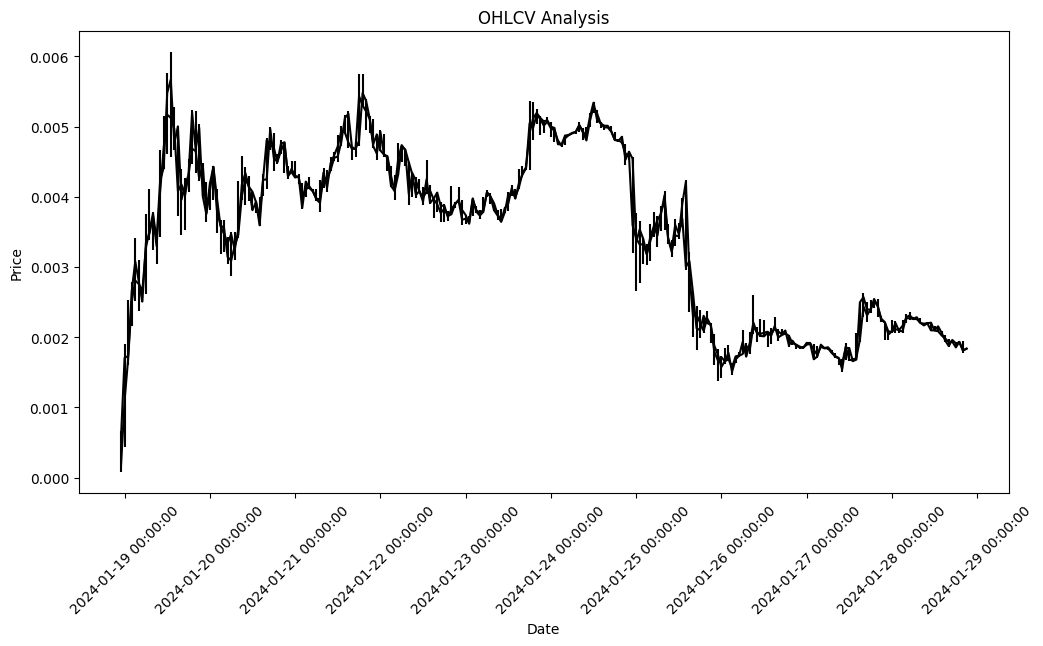

In [11]:
# Extracting OHLCV data
ohlc_data = dakko_client.get_query_results(dakko_sql).dataframe
ohlc_data["ts"] = pd.to_datetime(ohlc_data["ts"])

# Plotting the OHLCV chart
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting line connecting opens
ax.plot_date(ohlc_data["ts"], ohlc_data["open"], "k-")
# Plotting line connecting closes
ax.plot_date(ohlc_data["ts"], ohlc_data["close"], "k-")
ax.vlines(
    ohlc_data["ts"],
    ohlc_data["high"],
    ohlc_data["low"],
    colors="k",
    linestyles="solid",
)

# Formatting x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.xticks(rotation=45)

# Setting labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("OHLCV Analysis")

plt.show()

#### Create Time series analysis on the closing price


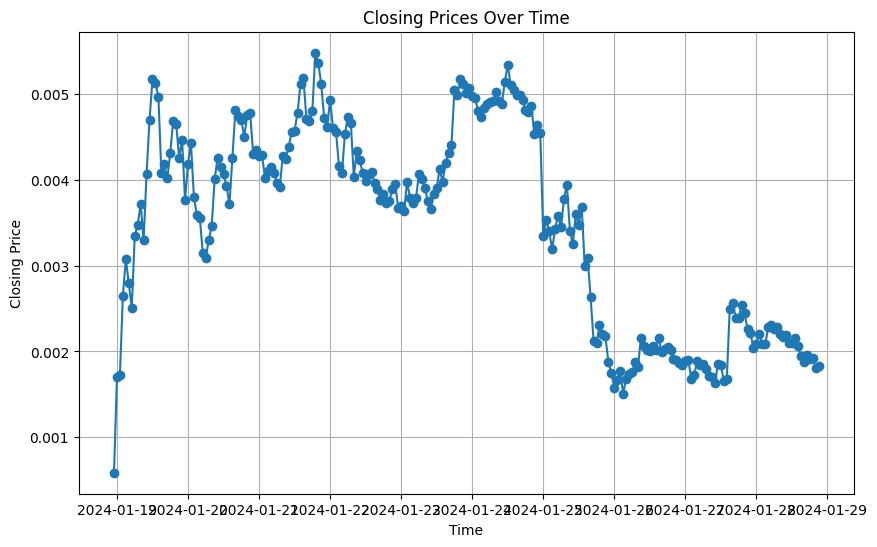

In [12]:
# Plotting the time series graph
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data["ts"], ohlc_data["close"], marker="o", linestyle="-")
plt.title("Closing Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.grid(True)
plt.show()

#### Let's now plot sync event data


/var/folders/1r/8b52x9qx5lj_b6pr8pwn1g3800pfld/T/ipykernel_49988/2563279878.py:65: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



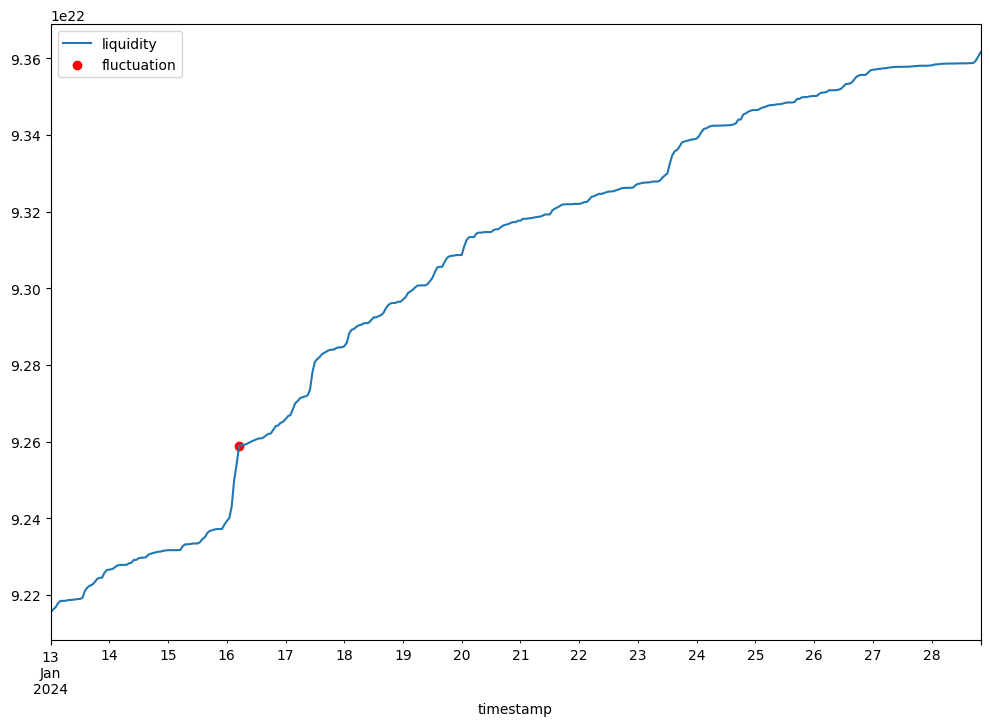

In [13]:
SEARCH_ADDRESS = "0x704aD8d95C12D7FEA531738faA94402725acB035".lower()

dakko_sync_sql = DakkoSearch(
    query=f"""
    
    select * 
    from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
    where address = '{SEARCH_ADDRESS}' 
    and event = 'Sync'
    
    """
)

sync_events = dakko_client.get_query_results(dakko_sync_sql).dataframe


def parse_args(df, names: str, args: str):
    # get first row of the column

    unique_names = df[names].unique()
    new_columns = [x.split(",") for x in unique_names]
    new_columns = reduce(lambda x, y: x + y, new_columns)

    df[new_columns] = None

    new_df = pd.DataFrame()

    for combo in unique_names:
        slice_df = df[df[names] == combo].copy()
        slice_df[combo.split(",")] = slice_df[args].str.split(";", expand=True)
        new_df = pd.concat([new_df, slice_df])

    new_df.drop(columns=[args, names], inplace=True)

    return new_df


sync_events["not_indexed_names"] = "reserve0,reserve1"
sync_events = parse_args(sync_events, "not_indexed_names", "not_indexed_args")
sync_events["timestamp"] = pd.to_datetime(sync_events["timestamp"])

dec0 = 1e18
dec1 = 1e18

sync_events["reserve0"] = sync_events["reserve0"].astype(float) / dec0
sync_events["reserve1"] = sync_events["reserve1"].astype(float) / dec1
sync_events.dropna(inplace=True)
sync_events.sort_values("timestamp", inplace=True)

sync_events["liquidity"] = (
    sync_events["reserve0"] * sync_events["reserve1"] * dec0 * dec1
) ** 0.5


sync_events["liquidity_diff"] = sync_events["liquidity"].diff()

fig, ax = plt.subplots(figsize=(12, 8))


temp_df = (
    sync_events[["timestamp", "liquidity"]]
    .set_index("timestamp")
    .resample("1H")
    .mean()
    .fillna(method="ffill")
)


temp_df.plot(y="liquidity", ax=ax)

ax.scatter(
    [sync_events.timestamp[sync_events.liquidity_diff.abs().idxmax()]],
    [sync_events.liquidity[sync_events.liquidity_diff.abs().idxmax()]],
    color="red",
    label="fluctuation",
)

ax.legend()

#### Liquidity distribution for uni3 pools


In [14]:
SEARCH_ADDRESS = "0xAD9eF19e289dcbC9AB27b83D2dF53CDEFF60f02D".lower()

dakko_ld_sql = DakkoSearch(
    query=f"""
    with 
        txhashes as (
            select distinct transactionHash 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where address = "{SEARCH_ADDRESS}" 
            and event = "Mint"
        ), 
        tokenIds as (
            select indexed_args 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where event in ("IncreaseLiquidity", "DecreaseLiquidity") 
            and transactionHash in (select transactionHash from txhashes)
        ) 
        select distinct * from (
            select * 
            from dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where address = "{SEARCH_ADDRESS}" 
            and event in ("Mint", "Burn") 
            union all 
            select * from 
            dakko_poc.eth_bronze.parsed_transaction_logs_refine 
            where event in ("IncreaseLiquidity", "DecreaseLiquidity") 
            and indexed_args in (select indexed_args from tokenIds)
        )
        join (select indexed_names, not_indexed_names, signature from dakko_poc.eth_static.event_registry_with_meta)
        using (signature)
        """
)

ld_df = dakko_client.get_query_results(dakko_ld_sql).dataframe
ld_df

,address,event,indexed_args,indexed_names,logIndex,not_indexed_args,not_indexed_names,signature,timestamp,transactionHash
0,0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d,Mint,0xc36442b4a4522e871399cd717abdd847ab11fe88;-56...,"owner,tickLower,tickUpper",0xd4,0xc36442b4a4522e871399cd717abdd847ab11fe88;473...,"sender,amount,amount0,amount1",0x7a53080ba414158be7ec69b987b5fb7d07dee101fe85...,2024-01-20T07:56:47+00:00,0xd904794d9714de13d99174383898959629d8f551a1de...
1,0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d,Burn,0x6b75d8af000000e20b7a7ddf000ba900b4009a80;-61...,"owner,tickLower,tickUpper",0x19,1370074193438352938631168;12889558417545889075...,"amount,amount0,amount1",0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,2024-01-19T02:16:11+00:00,0xb2fe0ecceec99d354cc8c1c2a01025ecd854187f858f...
2,0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d,Burn,0xc36442b4a4522e871399cd717abdd847ab11fe88;-61...,"owner,tickLower,tickUpper",0xce,31111821991350608175;653782165531207448378;359...,"amount,amount0,amount1",0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,2024-01-25T20:24:59+00:00,0x6675af69b780b1fcb5814c245e68bc7e7f8fce0785c7...
3,0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d,Mint,0xc36442b4a4522e871399cd717abdd847ab11fe88;-56...,"owner,tickLower,tickUpper",0x11d,0xc36442b4a4522e871399cd717abdd847ab11fe88;224...,"sender,amount,amount0,amount1",0x7a53080ba414158be7ec69b987b5fb7d07dee101fe85...,2024-01-21T22:54:23+00:00,0xa682a3b342b9eef78683aa8fb0cc35076160bb0ca4d3...
4,0xad9ef19e289dcbc9ab27b83d2df53cdeff60f02d,Burn,0x6b75d8af000000e20b7a7ddf000ba900b4009a80;-57...,"owner,tickLower,tickUpper",0x10,1103802516481995276550144;0;629042506684851626733,"amount,amount0,amount1",0x0c396cd989a39f4459b5fa1aed6a9a8dcdbc45908acf...,2024-01-25T02:12:47+00:00,0xfd61a5fe251b9b981a0955faf6cdcae6ce5354bfc485...
...,...,...,...,...,...,...,...,...,...,...
9747,0xc36442b4a4522e871399cd717abdd847ab11fe88,IncreaseLiquidity,651077,tokenId,0x50,13648651941487928750;149709349255256723646;231...,"liquidity,amount0,amount1",0x3067048beee31b25b2f1681f88dac838c8bba36af25b...,2024-01-19T01:57:35+00:00,0xacd6c281b90c61bb9e0c03b050c77fff7eb8a5f61851...
9748,0xc36442b4a4522e871399cd717abdd847ab11fe88,DecreaseLiquidity,651123,tokenId,0xcd,2229617362418370838;14436787185656690247;93132...,"liquidity,amount0,amount1",0x26f6a048ee9138f2c0ce266f322cb99228e8d619ae2b...,2024-01-24T17:27:59+00:00,0x5f863d4bf68d92312a32a7f718622f3767a29134c809...
9749,0xc36442b4a4522e871399cd717abdd847ab11fe88,DecreaseLiquidity,657664,tokenId,0x7,1889458272651292499203;3029340828876306142818;...,"liquidity,amount0,amount1",0x26f6a048ee9138f2c0ce266f322cb99228e8d619ae2b...,2024-01-24T23:30:23+00:00,0xac008575bdbe1f0d91cc565e8f0f4f1f3355ddef8d87...
9750,0xc36442b4a4522e871399cd717abdd847ab11fe88,DecreaseLiquidity,657668,tokenId,0x24a,31578221511344888677;46067844881043852378;0,"liquidity,amount0,amount1",0x26f6a048ee9138f2c0ce266f322cb99228e8d619ae2b...,2024-01-25T05:35:35+00:00,0x1955d1cd7f80a2b9dd58fb7277664151256ccff9d32c...


Processing liquidity events


In [15]:
liqiq = parse_args(ld_df, "indexed_names", "indexed_args")
liqiq = parse_args(liqiq, "not_indexed_names", "not_indexed_args")
liqiq["timestamp"] = pd.to_datetime(liqiq["timestamp"])

# copy events with token id
liqiq_id = liqiq[liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])].copy()

# copy events without token id
liquiq_not_id = liqiq[
    ~liqiq.event.isin(["DecreaseLiquidity", "IncreaseLiquidity"])
].copy()

# build mapping between positions and tick ranges
tokenId_to_ticks = (
    (
        liqiq_id.drop(columns=["tickUpper", "tickLower"]).merge(
            liquiq_not_id[["transactionHash", "tickUpper", "tickLower"]],
            how="inner",
            on="transactionHash",
        )
    )[["tokenId", "tickUpper", "tickLower"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .to_dict("records")
)

# remap
tokenId_to_ticks_new = dict()

for x in tokenId_to_ticks:
    tokenId_to_ticks_new[x["tokenId"]] = (x["tickUpper"], x["tickLower"])

# apply for original df

liqiq["tickUpper"] = liqiq.apply(
    lambda x: (
        tokenId_to_ticks_new[x["tokenId"]][0]
        if x["tokenId"] is not None
        else x["tickUpper"]
    ),
    axis=1,
)
liqiq["tickLower"] = liqiq.apply(
    lambda x: (
        tokenId_to_ticks_new[x["tokenId"]][1]
        if x["tokenId"] is not None
        else x["tickLower"]
    ),
    axis=1,
)

# rebuild liquidity column using all events now
liqiq.liquidity = liqiq.apply(
    lambda x: float(x.liquidity) if x.liquidity is not None else float(x.amount), axis=1
)

# convert to numeric
for col in ["amount0", "amount1"]:
    liqiq[col] = liqiq[col].astype(float)

liqiq.tickLower = liqiq.tickLower.astype(int)
liqiq.tickUpper = liqiq.tickUpper.astype(int)

# add multiplier for corresponding events
for col in ["liquidity", "amount0", "amount1"]:
    liqiq[col] *= liqiq.event.apply(
        lambda x: -1 if x in ["DecreaseLiquidity", "Burn"] else 1
    )

In [16]:
# extract liquidity distribution using liquidity dataframe preprocessed
def get_liq_ticks(df: pd.DataFrame, dec0: int = 18, dec1: int = 18):
    unique_ticks = sorted(set(df["tickLower"]).union(set(df["tickUpper"])))

    tick_liquidity = pd.DataFrame(unique_ticks, columns=["tick"]).set_index("tick")
    tick_liquidity["totalLiquidity"] = 0
    tick_liquidity["amount0locked"] = 0
    tick_liquidity["amount1locked"] = 0

    for _, row in df.iterrows():
        tick_liquidity.loc[
            row["tickLower"] : row["tickUpper"], "totalLiquidity"
        ] += row["liquidity"]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount0locked"] += row[
            "amount0"
        ]
        tick_liquidity.loc[row["tickLower"] : row["tickUpper"], "amount1locked"] += row[
            "amount1"
        ]

    tick_liquidity = tick_liquidity.reset_index()

    tick_liquidity["price"] = 1.0001 ** tick_liquidity["tick"] * 10 ** (dec1 - dec0)

    tick_liquidity["tick_width"] = tick_liquidity["tick"].diff().shift(-1).fillna(0)
    tick_liquidity["price_width"] = tick_liquidity["price"].diff().shift(-1).fillna(0)

    return tick_liquidity

In [17]:
from datetime import timedelta

# last available liquidity state
tick_liquidity = get_liq_ticks(liqiq)

# liquidity state 4 days before last state available
tick_liquidity_past_snap = get_liq_ticks(
    liqiq[liqiq["timestamp"] < liqiq["timestamp"].max() - timedelta(days=4)]
)

/var/folders/1r/8b52x9qx5lj_b6pr8pwn1g3800pfld/T/ipykernel_49988/3289347335.py:11: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19 4.73637111e+19 4.73637111e+19 4.73637111e+19
 4.73637111e+19]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/var/folders/1r/8b52x9qx5lj_b6pr8pwn1g3800pfld/T/ipykernel_49988/3289347335.py:14:

Get two nearest swap events and use price from there


In [18]:
max_ts = int(liqiq["timestamp"].max().timestamp())
ts_ago = int((liqiq["timestamp"].max() - timedelta(days=4)).timestamp())

SEARCH_ADDRESS = "0xAD9eF19e289dcbC9AB27b83D2dF53CDEFF60f02D".lower()

dakko_sql = DakkoSearch(
    query=f"""
    
    WITH 
        Constants AS (
            SELECT 
                '{SEARCH_ADDRESS}' AS contract, 
                18 AS dec0, 
                18 AS dec1,
                timestamp({max_ts}) AS max_ts,
                timestamp({ts_ago}) AS ts_ago,
                30 as search_width
        ), 
        PreparedData AS (
            SELECT 
                `timestamp`,
                pow(sqrtPriceX96 / pow(2, 96), 2) * pow(10, dec0 - dec1) AS price,
                tick 
            FROM dakko_poc.eth_demo.token_swaps_raw, Constants
            WHERE address = lower(contract)
        ) 
        
    SELECT * FROM (SELECT price, tick
    FROM PreparedData, Constants 
    WHERE abs(TIMESTAMPDIFF(SECOND, `timestamp`, max_ts)) < search_width
    ORDER BY `timestamp` DESC
    LIMIT 1)
    UNION ALL
    SELECT * FROM (SELECT price, tick
    FROM PreparedData, Constants 
    WHERE abs(TIMESTAMPDIFF(SECOND, `timestamp`, ts_ago)) < search_width
    ORDER BY `timestamp` DESC
    LIMIT 1)
    
    """
)

last_swaps = dakko_client.get_query_results(dakko_sql).dataframe
last_price, last_price_past_snap = last_swaps.price.values
last_tick, last_tick_past_snap = last_swaps.tick.astype(int).values

Plot liquidity distribution in tick space


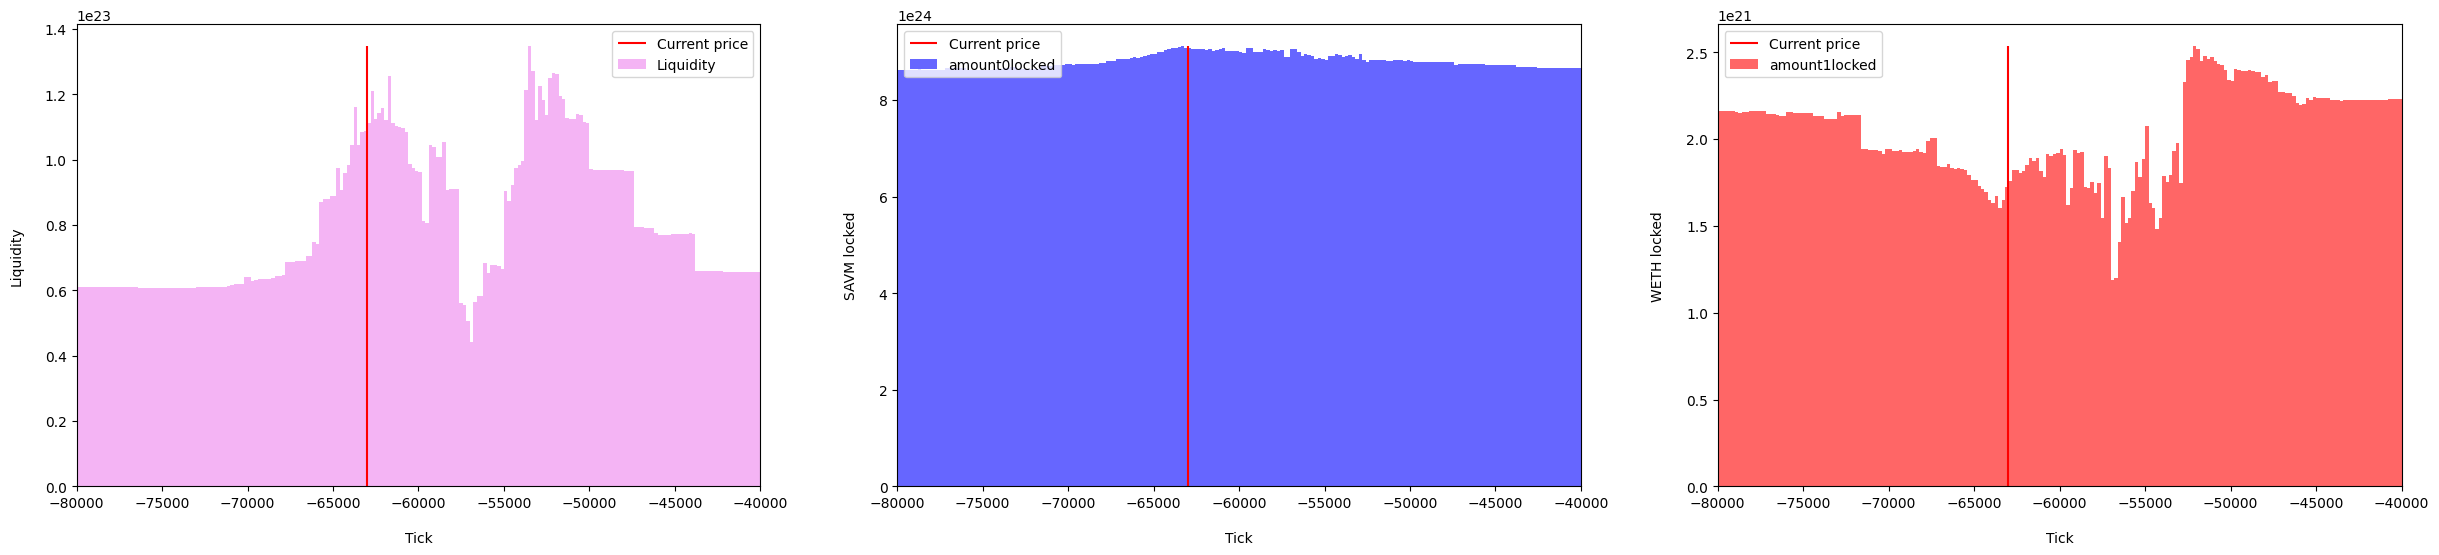

In [19]:
import matplotlib.pyplot as plt

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

ax.bar(
    tick_liquidity["tick"],
    tick_liquidity["totalLiquidity"],
    width=tick_liquidity["tick_width"],
    align="edge",
    alpha=0.6,
    color="violet",
    label="Liquidity",
)

ax2.bar(
    tick_liquidity["tick"],
    tick_liquidity["amount0locked"],
    width=tick_liquidity["tick_width"],
    align="edge",
    alpha=0.6,
    color="blue",
    label="amount0locked",
)

ax3.bar(
    tick_liquidity["tick"],
    tick_liquidity["amount1locked"],
    width=tick_liquidity["tick_width"],
    align="edge",
    alpha=0.6,
    color="red",
    label="amount1locked",
)

for a, col in zip((ax, ax2, ax3), ("totalLiquidity", "amount0locked", "amount1locked")):
    a.vlines(
        last_tick,
        0,
        tick_liquidity[col].max(),
        color="red",
        alpha=1,
        label="Current price",
    )

ax.set_ylabel("Liquidity", labelpad=15)
ax2.set_ylabel("SAVM locked", labelpad=15)
ax3.set_ylabel("WETH locked", labelpad=15)
ax.set_xlabel("Tick", labelpad=15)
ax2.set_xlabel("Tick", labelpad=15)
ax3.set_xlabel("Tick", labelpad=15)

ax.set_xlim(-8e4, -4e4)
ax2.set_xlim(-8e4, -4e4)
ax3.set_xlim(-8e4, -4e4)

ax.legend()
ax2.legend()
ax3.legend()

Liquidity distribution in price space


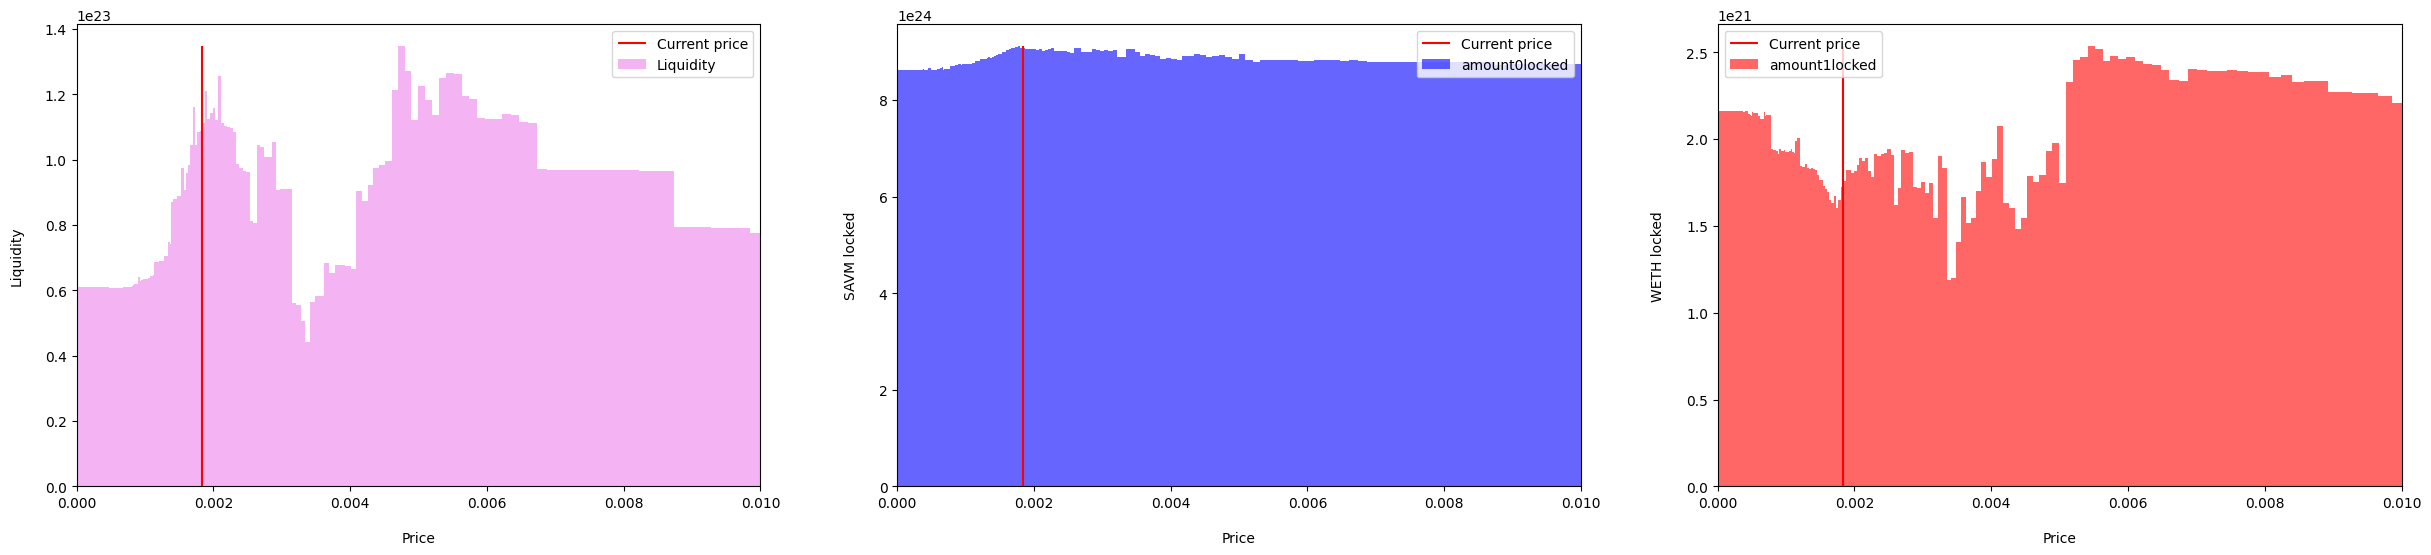

In [20]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 6))

ax.bar(
    tick_liquidity["price"],
    tick_liquidity["totalLiquidity"],
    width=tick_liquidity["price_width"],
    align="edge",
    alpha=0.6,
    color="violet",
    label="Liquidity",
)

ax2.bar(
    tick_liquidity["price"],
    tick_liquidity["amount0locked"],
    width=tick_liquidity["price_width"],
    align="edge",
    alpha=0.6,
    color="blue",
    label="amount0locked",
)

ax3.bar(
    tick_liquidity["price"],
    tick_liquidity["amount1locked"],
    width=tick_liquidity["price_width"],
    align="edge",
    alpha=0.6,
    color="red",
    label="amount1locked",
)

for a, col in zip((ax, ax2, ax3), ("totalLiquidity", "amount0locked", "amount1locked")):
    a.vlines(
        last_price,
        0,
        tick_liquidity[col].max(),
        color="red",
        alpha=1,
        label="Current price",
    )

ax.set_ylabel("Liquidity", labelpad=15)
ax2.set_ylabel("SAVM locked", labelpad=15)
ax3.set_ylabel("WETH locked", labelpad=15)
ax.set_xlabel("Price", labelpad=15)
ax2.set_xlabel("Price", labelpad=15)
ax3.set_xlabel("Price", labelpad=15)

ax.set_xlim(0, 1e-2)
ax2.set_xlim(0, 1e-2)
ax3.set_xlim(0, 1e-2)

ax.legend()
ax2.legend()
ax3.legend()

Plot liquidity distribution difference in tick space


Text(0.5, 0, 'Tick')

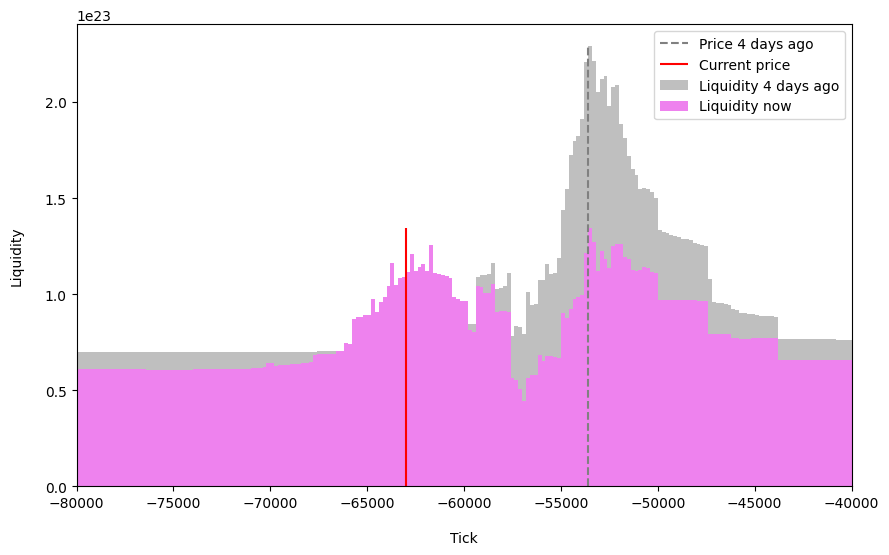

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    tick_liquidity_past_snap["tick"],
    tick_liquidity_past_snap["totalLiquidity"],
    width=tick_liquidity_past_snap["tick_width"],
    align="edge",
    alpha=0.5,
    color="gray",
    label="Liquidity 4 days ago",
)
ax.vlines(
    last_tick_past_snap,
    0,
    tick_liquidity_past_snap["totalLiquidity"].max(),
    color="gray",
    linestyle="--",
    alpha=1,
    label="Price 4 days ago",
)

ax.bar(
    tick_liquidity["tick"],
    tick_liquidity["totalLiquidity"],
    width=tick_liquidity["tick_width"],
    align="edge",
    alpha=1,
    color="violet",
    label="Liquidity now",
)
ax.vlines(
    last_tick,
    0,
    tick_liquidity["totalLiquidity"].max(),
    color="red",
    alpha=1,
    label="Current price",
)

ax.set_xlim(-8e4, -4e4)
ax.legend()

ax.set_ylabel("Liquidity", labelpad=15)
ax.set_xlabel("Tick", labelpad=15)

Plot liquidity difference in price space


Text(0.5, 0, 'Price')

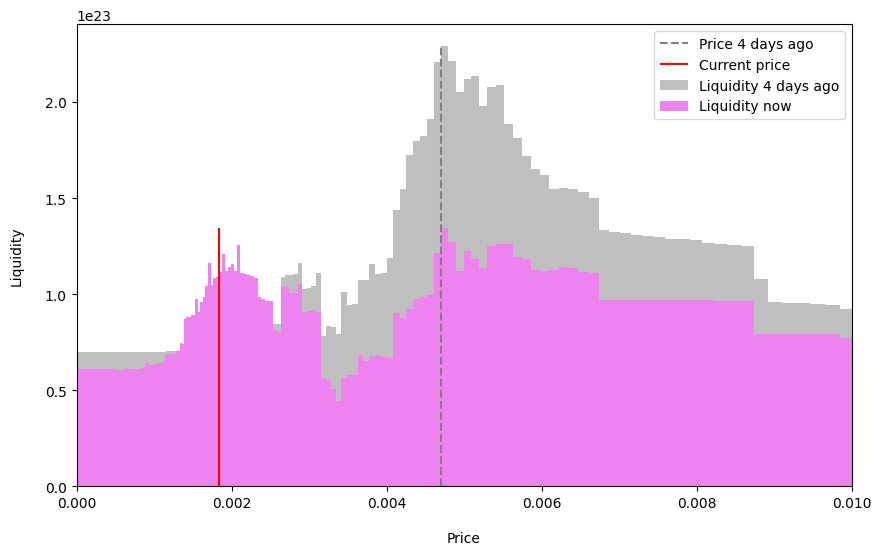

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    tick_liquidity_past_snap["price"],
    tick_liquidity_past_snap["totalLiquidity"],
    width=tick_liquidity_past_snap["price_width"],
    align="edge",
    alpha=0.5,
    color="gray",
    label="Liquidity 4 days ago",
)
ax.vlines(
    last_price_past_snap,
    0,
    tick_liquidity_past_snap["totalLiquidity"].max(),
    color="gray",
    linestyle="--",
    alpha=1,
    label="Price 4 days ago",
)

ax.bar(
    tick_liquidity["price"],
    tick_liquidity["totalLiquidity"],
    width=tick_liquidity["price_width"],
    align="edge",
    alpha=1,
    color="violet",
    label="Liquidity now",
)
ax.vlines(
    last_price,
    0,
    tick_liquidity["totalLiquidity"].max(),
    color="red",
    alpha=1,
    label="Current price",
)

ax.set_xlim(0, 1e-2)
ax.legend()

ax.set_ylabel("Liquidity", labelpad=15)
ax.set_xlabel("Price", labelpad=15)

#### Fetch Wallet Labels for Top wallets


In [23]:
# Search for Wallet labels from Dakko
# dakko_search_wallets_labels = DakkoSearch(
#     query='kucoin'
# )

dakko_search_wallets_labels = DakkoSearch(query="binance")

# dakko_search_wallets_labels = DakkoSearch(
#     query='bybit'
# )

wallet_labels = dakko_client.get_wallet_labels(dakko_search_wallets_labels).dataframe

print("Search for Top Wallet Labels")
print(wallet_labels)

Search for Top Wallet Labels
                                      address  \
0  0xbe0eb53f46cd790cd13851d5eff43d12404d33e8   
1  0xf977814e90da44bfa03b6295a0616a897441acec   
2  0x5a52e96bacdabb82fd05763e25335261b270efcb   
3  0x28c6c06298d514db089934071355e5743bf21d60   
4  0x9696f59e4d72e237be84ffd425dcad154bf96976   
5  0x21a31ee1afc51d94c2efccaa2092ad1028285549   
6  0xdfd5293d8e347dfe59e90efd55b2956a1343963d   
7  0x56eddb7aa87536c09ccc2793473599fd21a8b17f   
8  0x4976a4a02f38326660d17bf34b431dc6e2eb2327   
9  0xa344c7ada83113b3b56941f6e85bf2eb425949f3   

                                           labels  
0  [{'label_type': 'binance', 'confidence': 1.0}]  
1  [{'label_type': 'binance', 'confidence': 1.0}]  
2  [{'label_type': 'binance', 'confidence': 1.0}]  
3  [{'label_type': 'binance', 'confidence': 1.0}]  
4  [{'label_type': 'binance', 'confidence': 1.0}]  
5  [{'label_type': 'binance', 'confidence': 1.0}]  
6  [{'label_type': 'binance', 'confidence': 1.0}]  
7  [{'label_typ

In [24]:
# Search for Wallet labels from Dakko Dataframe
dakko_search_wallets_labels = DakkoSearch()

wallet_labels_dataframe = dakko_client.get_wallet_labels(
    dakko_search_wallets_labels
).dataframe

print("Search for Top Wallet Labels Dataframe")
print(wallet_labels_dataframe)

Search for Top Wallet Labels Dataframe
                                      address  \
0  0xbe0eb53f46cd790cd13851d5eff43d12404d33e8   
1  0xf977814e90da44bfa03b6295a0616a897441acec   
2  0x5a52e96bacdabb82fd05763e25335261b270efcb   
3  0x28c6c06298d514db089934071355e5743bf21d60   
4  0x9696f59e4d72e237be84ffd425dcad154bf96976   
5  0x21a31ee1afc51d94c2efccaa2092ad1028285549   
6  0xdfd5293d8e347dfe59e90efd55b2956a1343963d   
7  0x56eddb7aa87536c09ccc2793473599fd21a8b17f   
8  0x4976a4a02f38326660d17bf34b431dc6e2eb2327   
9  0xa344c7ada83113b3b56941f6e85bf2eb425949f3   

                                           labels  
0  [{'label_type': 'binance', 'confidence': 1.0}]  
1  [{'label_type': 'binance', 'confidence': 1.0}]  
2  [{'label_type': 'binance', 'confidence': 1.0}]  
3  [{'label_type': 'binance', 'confidence': 1.0}]  
4  [{'label_type': 'binance', 'confidence': 1.0}]  
5  [{'label_type': 'binance', 'confidence': 1.0}]  
6  [{'label_type': 'binance', 'confidence': 1.0}]  
7  [{